### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [43]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.clustering import *
from model_scripts.model_visualiser import *
from evaluation_scripts.result_visualiser import *
from evaluation_scripts.label_helper import *
from Pipeline.temporal_preprocessing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

In [ ]:
# temp_pipeline = PreProcessingPipelineTemporal()

In [ ]:
# train_fn, dataloader_train = temp_pipeline.get_processed_trainloader(64, 'indexbands', vi_type='msi')

Train

In [14]:
temporal_images = load_field_images_temporal(config.load_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
field_numbers_train, acq, indices_images_train = allbands_temporal_cubes(border_removed_images_train)

len(indices_images_train), indices_images_train[0][0].shape

(2425, (64, 64, 10))

Evaluation

In [15]:
temporal_images_eval = load_field_images_temporal(config.load_directory_temporal_eval)
border_removed_images = blacken_field_borders_temporal(temporal_images_eval)
field_numbers_eval, acq, indices_images_eval = allbands_temporal_cubes(border_removed_images)

(len(indices_images_eval), indices_images_eval[0][0].shape)

(48, (64, 64, 10))

In [16]:
image_tensor_train = np.stack(indices_images_train)  # Shape: (N x 7 x 64 x 64 x 6)
image_tensor_eval = np.stack(indices_images_eval)   # Shape: (N x 7 x 64 x 64 x 6)

image_tensor_train.shape, image_tensor_eval.shape

((2425, 7, 64, 64, 10), (48, 7, 64, 64, 10))

In [17]:
image_tensor_train = torch.tensor(image_tensor_train, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_eval = torch.tensor(image_tensor_eval, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_train.shape, image_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Temporary Cells for getting pictures for our thesis

In [18]:
indices_images_train[0][0].shape

(64, 64, 10)

In [19]:
visualize_temporal_stack_rgb(temporal_images_eval[47])

TypeError: visualize_temporal_stack_rgb() missing 1 required positional argument: 'dates'

In [20]:
visualize_temporal_stack_ndvi(temporal_images_eval[47])

TypeError: visualize_temporal_stack_ndvi() missing 1 required positional argument: 'dates'

In [21]:
visualize_temporal_stack_msi(temporal_images_eval[47])

TypeError: visualize_temporal_stack_msi() missing 1 required positional argument: 'dates'

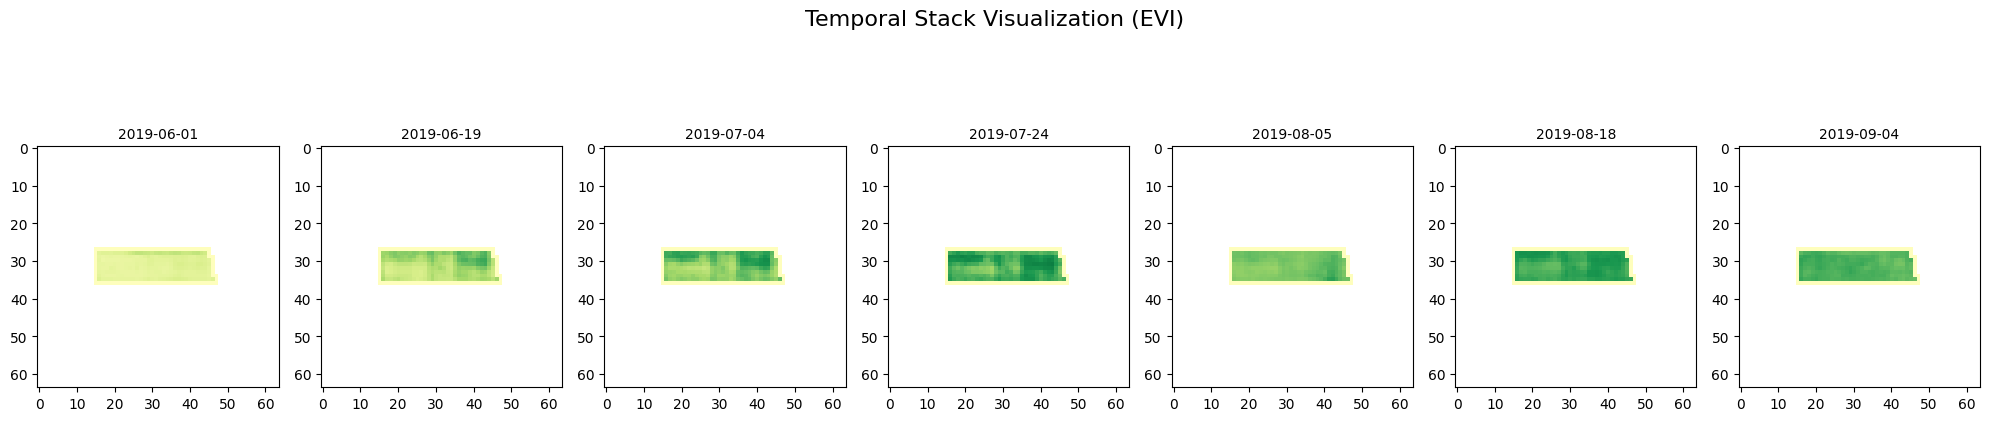

In [ ]:
visualize_temporal_stack_evi(temporal_images_eval[47])

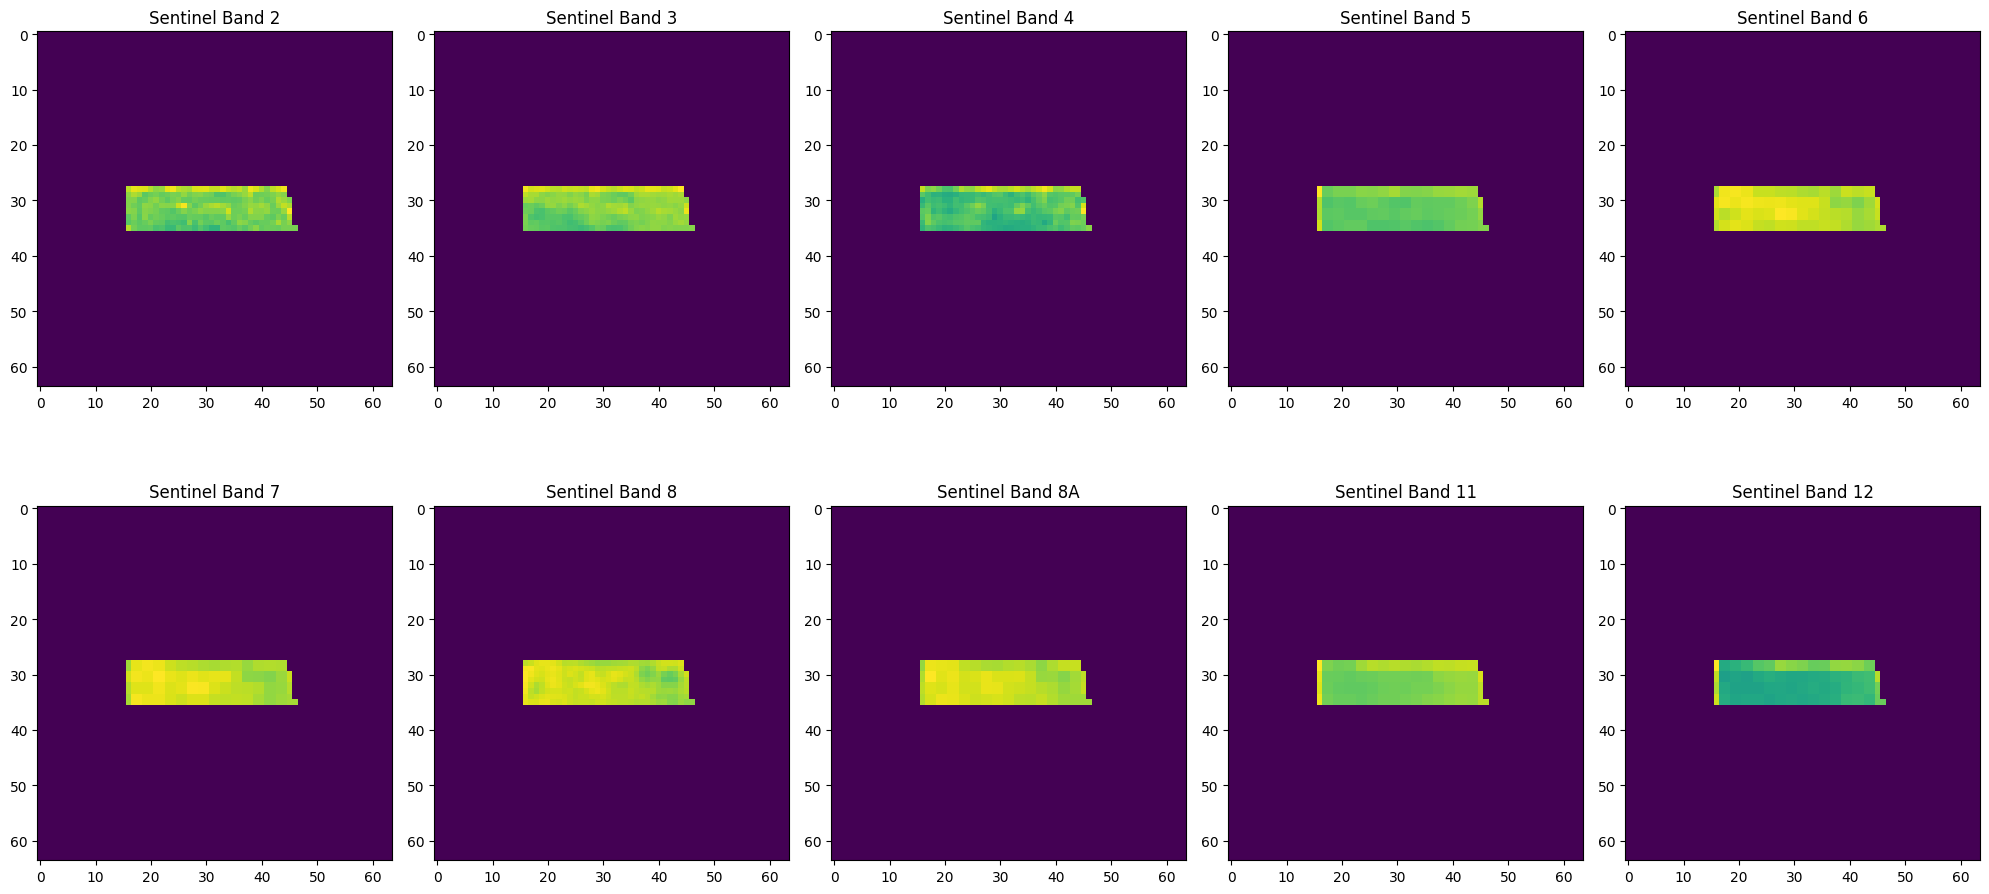

In [ ]:
visualise_all_bands_wo_masks(temporal_images_eval[47][-1])

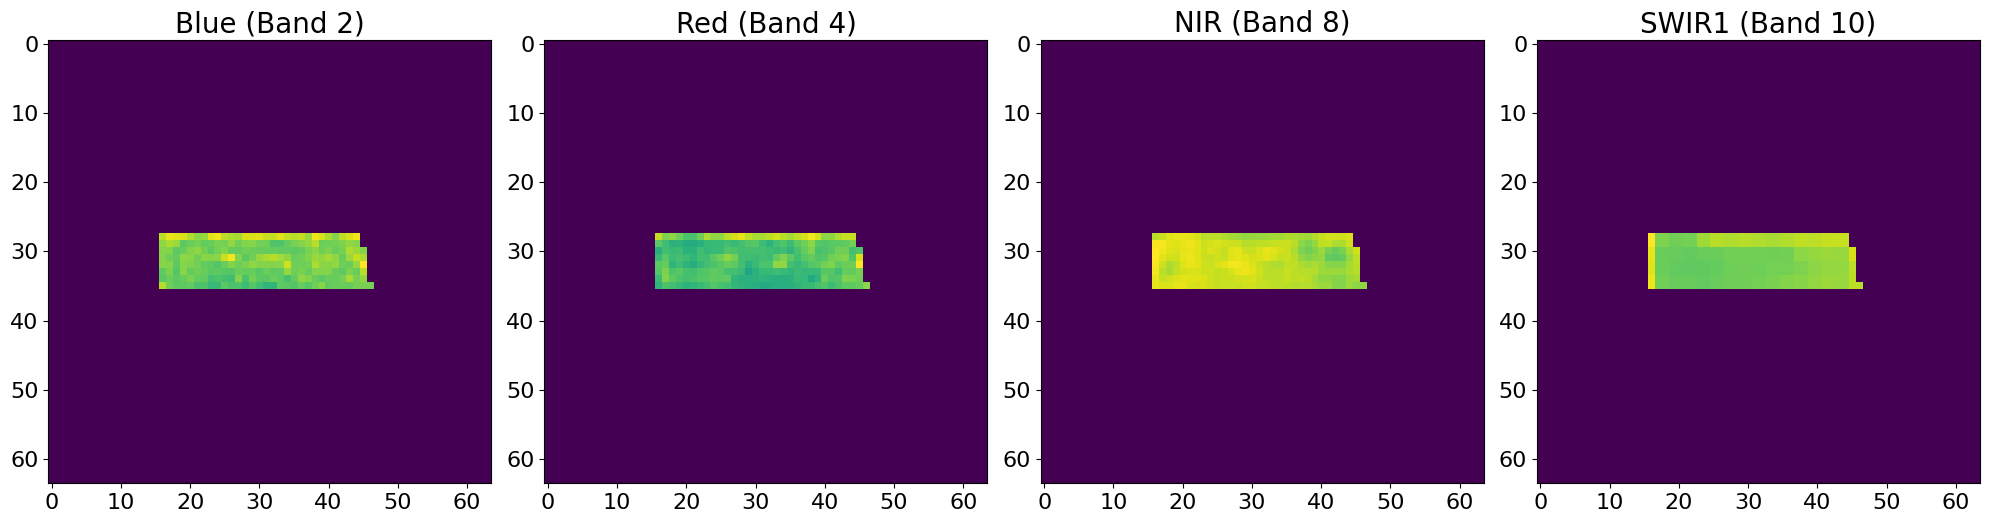

In [ ]:
visualise_selected_bands(temporal_images_eval[47][-1])

In [ ]:
np.unique(temporal_images_eval[47][-1][:,:,-2])

array([      0., 1230818.])

### Mini-patches

In [22]:
train_patches, train_patch_coordinates = non_overlapping_sliding_window(image_tensor_train, field_numbers_train, patch_size=5)
eval_patches, eval_patch_coordinates = non_overlapping_sliding_window(image_tensor_eval, field_numbers_eval, patch_size=5)
len(eval_patches), eval_patches[0].shape

(867, torch.Size([7, 10, 5, 5]))

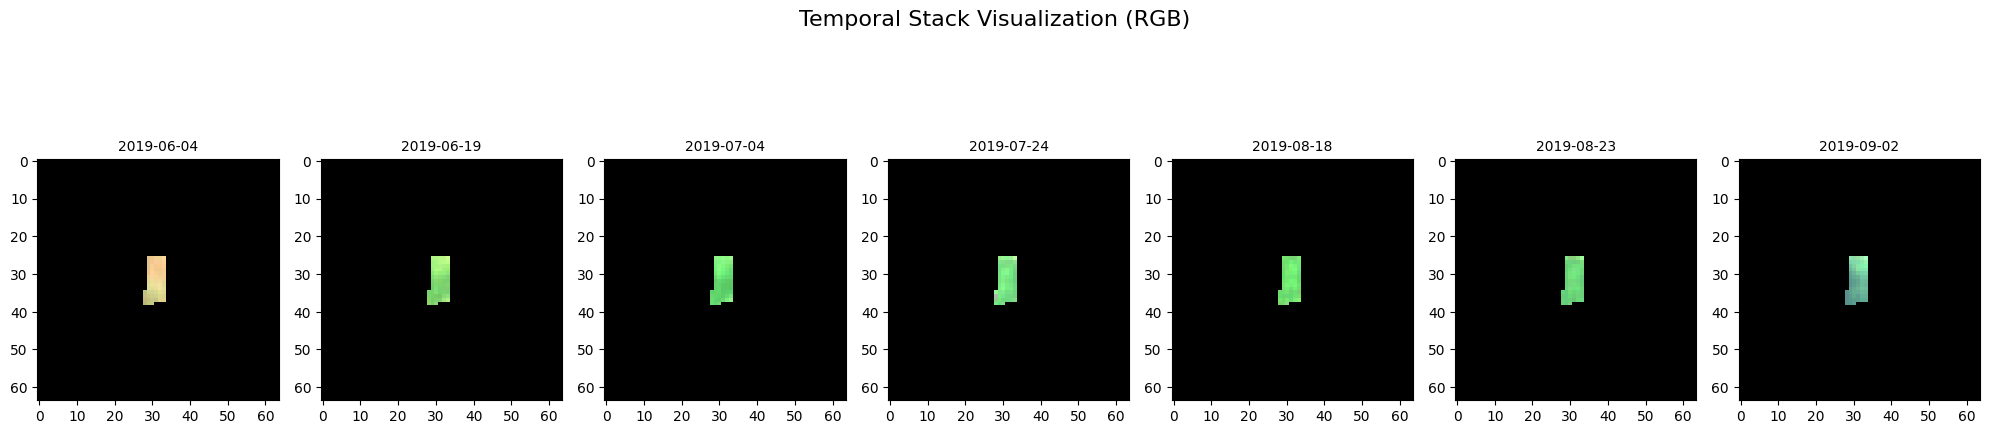

In [ ]:
visualize_temporal_stack_rgb(temporal_images[0])

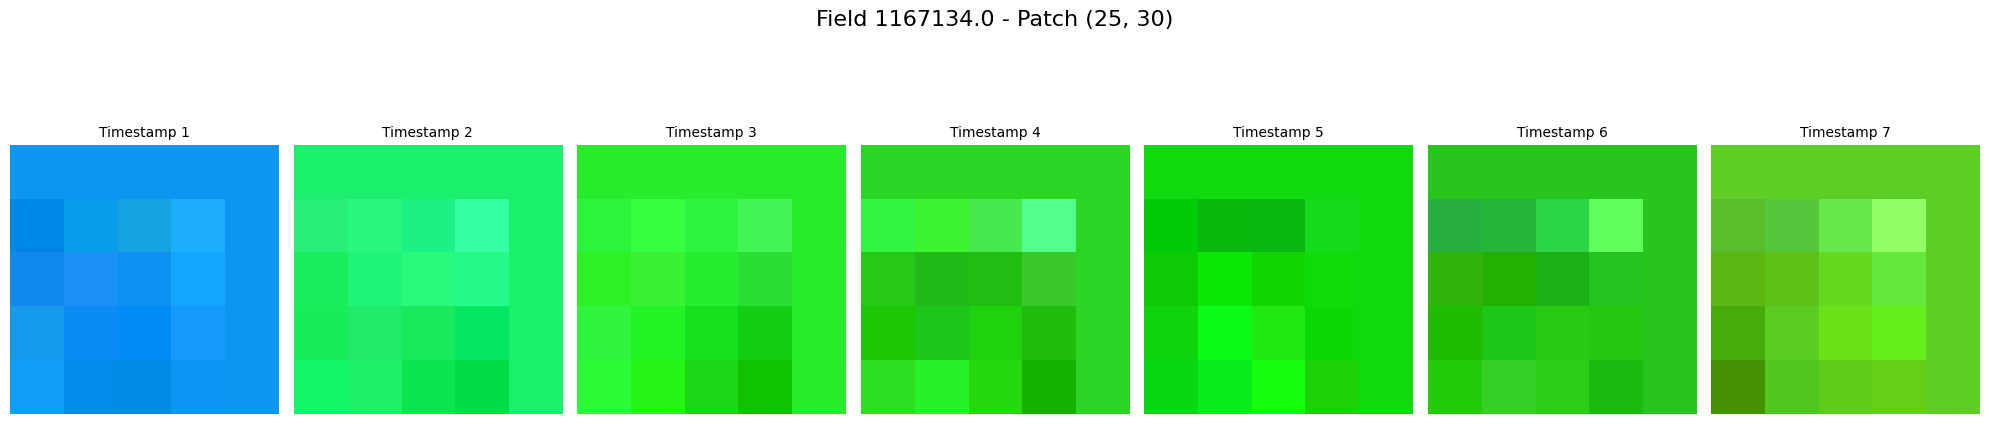

In [ ]:
visualize_single_patch_temporal_rgb(train_patches[1],train_patch_coordinates[1])

In [23]:
len(train_patches), len(train_patch_coordinates)

(39042, 39042)

In [24]:
train_patches = np.stack(train_patches)  # Shape: (N x 7 x 6 x 5 x 5)
eval_patches = np.stack(eval_patches)   # Shape: (N x 7 x 6 x 5 x 5)

In [25]:
train_patch_coordinates[0]

('1167134.0', 25, 25)

In [26]:
train_coord_dataloader = get_string_fielddata(train_patch_coordinates)
eval_coord_dataloader = get_string_fielddata(eval_patch_coordinates)
train_coord_dataloader[0]

'1167134.0_25_25'

In [27]:
len(train_coord_dataloader)

39042

### Data Loaders

In [28]:
# batch_size = 64
# dataloader_train = create_data_loader(train_patches, train_coord_dataloader, batch_size=batch_size, shuffle=True)

# for batch_inputs, batch_field_numbers in dataloader_train:
#     print("Batch Inputs Shape:", batch_inputs.shape) 
#     print("Batch Field Numbers:", batch_field_numbers)
#     break  

In [29]:
train_patches.shape

(39042, 7, 10, 5, 5)

In [30]:
len(train_coord_dataloader)

39042

In [31]:
len(train_patch_coordinates)

39042

In [32]:
train_ratio = 0.8  

# Split patches and corresponding field numbers
train_patches, test_patches, train_field_numbers, test_field_numbers = train_test_split(
    train_patches, train_coord_dataloader, test_size=1-train_ratio, random_state=42
)

# Create train and test dataloaders
batch_size = 64
dataloader_train = create_data_loader(train_patches, train_field_numbers, batch_size=batch_size, shuffle=True)
dataloader_test = create_data_loader(test_patches, test_field_numbers, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_train:
    print("Train Batch Inputs Shape:", batch_inputs.shape)
    print("Train Batch Field Numbers:", batch_field_numbers)
    break  

for batch_inputs, batch_field_numbers in dataloader_test:
    print("Test Batch Inputs Shape:", batch_inputs.shape)
    print("Test Batch Field Numbers:", batch_field_numbers)
    break  

Train Batch Inputs Shape: torch.Size([64, 10, 7, 5, 5])
Train Batch Field Numbers: ('1223197.0_1223199.0_1223204.0_1223208.0_25_35', '1225271.0_1228634.0_40_45', '1226152.0_35_40', '1183210.0_1224132.0_25_35', '1217347.0_1217351.0_30_25', '1175688.0_30_30', '1223544.0_30_25', '1216165.0_20_30', '1219414.0_30_15', '1225753.0_35_35', '1167215.0_25_30', '1170186.0_1196410.0_1223959.0_20_20', '1217499.0_25_30', '1185902.0_1215721.0_1223285.0_1223290.0_1224130.0_1224133.0_1224134.0_30_20', '1186322.0_20_20', '1223940.0_35_35', '1215714.0_1220162.0_1223849.0_40_35', '1177286.0_1218444.0_35_30', '1222608.0_1223845.0_1229974.0_10_40', '1219492.0_1223205.0_40_35', '1167553.0_1169810.0_35_25', '1222833.0_40_30', '1177566.0_45_35', '1182097.0_1217088.0_1217802.0_1217808.0_1219048.0_1219049.0_1221032.0_1227443.0_1227447.0_1227451.0_10_45', '1179944.0_1179946.0_1179949.0_1179950.0_1179951.0_1179953.0_1228193.0_1228194.0_1228196.0_50_20', '1170186.0_1196410.0_1223959.0_45_15', '1222246.0_1224382.0_3

In [33]:
batch_size = 64
dataloader_eval = create_data_loader(eval_patches, eval_coord_dataloader, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_eval:
    print("Eval Batch Inputs Shape:", batch_inputs.shape) 
    print("Eval Batch Field Numbers:", batch_field_numbers)
    break  

Eval Batch Inputs Shape: torch.Size([64, 10, 7, 5, 5])
Eval Batch Field Numbers: ('1168039.0_20_25', '1168039.0_20_30', '1168039.0_20_35', '1168039.0_25_25', '1168039.0_25_30', '1168039.0_25_35', '1168039.0_30_25', '1168039.0_30_30', '1168039.0_30_35', '1168039.0_35_25', '1168039.0_35_30', '1168039.0_35_35', '1228889.0_25_15', '1228889.0_25_20', '1228889.0_25_25', '1228889.0_25_30', '1228889.0_25_35', '1228889.0_25_40', '1228889.0_30_15', '1228889.0_30_20', '1228889.0_30_25', '1228889.0_30_30', '1228889.0_30_35', '1228889.0_30_40', '1228889.0_35_15', '1228889.0_35_20', '1228889.0_35_25', '1228889.0_35_30', '1168663.0_1176271.0_25_35', '1168663.0_1176271.0_25_40', '1168663.0_1176271.0_30_20', '1168663.0_1176271.0_30_25', '1168663.0_1176271.0_30_30', '1168663.0_1176271.0_30_35', '1168663.0_1176271.0_30_40', '1168663.0_1176271.0_35_20', '1168663.0_1176271.0_35_25', '1168663.0_1176271.0_35_30', '1168663.0_1176271.0_35_35', '1168663.0_1176271.0_35_40', '1168692.0_1220431.0_15_20', '1168692.

### Modeling - Autoencoder

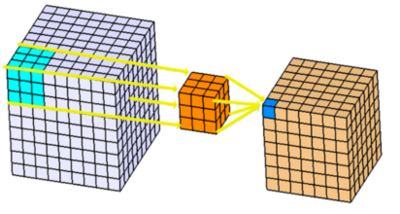

Input Data: ( N x C x D x H x W )

In [35]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder ---
        self.conv1 = nn.Conv3d(in_channels, 128, kernel_size=3, stride=1, padding=1)  #[64, time_steps, 5, 5]
        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)  #[128, time_steps, 5, 5]
        self.conv3 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)  #[256, time_steps, 5, 5]

        # --- Linear layers ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * time_steps * 5 * 5, 1024)  
        self.fc2 = nn.Linear(1024, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 1024)
        self.fc4 = nn.Linear(1024, 512 * time_steps * 5 * 5)  
        self.unflatten = nn.Unflatten(1, (512, time_steps, 5, 5))  

        self.deconv1 = nn.ConvTranspose3d(512, 256, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(128, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu((self.conv1(x)))  #[64, time_steps, 5, 5]
        x = F.relu((self.conv2(x)))  #[128, time_steps, 5, 5]
        x = F.relu((self.conv3(x)))  #[256, time_steps, 5, 5]

        x_flat = self.flatten(x)
        # print(f"Flattened size before Linear: {x_flat.size()}")  # (batch_size, 256 * time_steps * 5 * 5)
        
        x = F.relu(self.fc1(x_flat))
        z = self.fc2(x)

        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = self.unflatten(x)

        x = F.relu((self.deconv1(x)))
        x = F.relu((self.deconv2(x)))
        x_reconstructed = self.deconv3(x)

        return z, x_reconstructed


### Training

In [38]:
# Train
device = 'cuda'
epochs = 2
lr = 0.01
latent_dim=1024
channels = 10
time_steps = 7

model = Conv3DAutoencoder(channels, time_steps, latent_dim)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=89600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=89600, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 7, 5, 5))
  (deconv1): ConvTranspose3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(128, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [39]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/2, Train Loss: 25489702133520.7500, Test Loss: 0.0029
Epoch 2/2, Train Loss: 0.0029, Test Loss: 0.0029


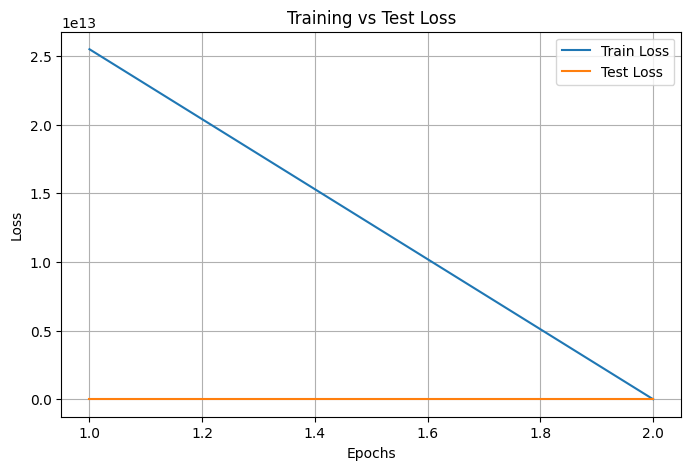

In [40]:
plot_loss(train_losses,test_losses)

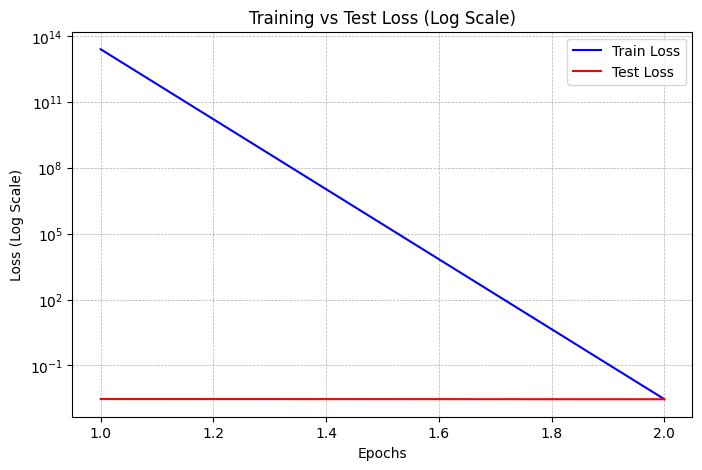

In [41]:
plot_loss_log_scale(train_losses, test_losses)

### Evaluation

In [48]:
# Extract features and field numbers
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [47]:
test_coord_dl[0]

'1222547.0_20_30'

In [44]:
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

In [45]:
kmeans = train_kmeans_patches(train_features.cpu(), n_clusters=2, random_state=8)
# kmeans = KMeans(n_clusters=2, random_state=2)
# kmeans.fit(train_features)

train_patch_predictions = kmeans.predict(train_features.reshape(train_features.size(0), -1).numpy().astype(np.float32))
test_patch_predictions = kmeans.predict(test_features.reshape(test_features.size(0), -1).numpy().astype(np.float32))
eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


resume

In [49]:
# Assign field labels
threshold = 0.5
train_field_labels = assign_field_labels_ae(train_coord_dl, train_patch_predictions, threshold)
test_field_labels = assign_field_labels_ae(test_coord_dl, test_patch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_patch_predictions, threshold)

In [51]:
train_coord_dl[1]

'1180792.0_1185840.0_1216711.0_1225856.0_1228645.0_25_35'

In [ ]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

Test Accuracy: 0.5573770491803278
              precision    recall  f1-score   support

           0       0.47      0.31      0.37        26
           1       0.59      0.74      0.66        35

    accuracy                           0.56        61
   macro avg       0.53      0.53      0.52        61
weighted avg       0.54      0.56      0.54        61



In [ ]:
x_y_coords 

{('1168039.0_20_25', (20, 25)): 1,
 ('1168039.0_20_30', (20, 30)): 1,
 ('1168039.0_20_35', (20, 35)): 1,
 ('1168039.0_25_25', (25, 25)): 1,
 ('1168039.0_25_30', (25, 30)): 1,
 ('1168039.0_25_35', (25, 35)): 1,
 ('1168039.0_30_25', (30, 25)): 1,
 ('1168039.0_30_30', (30, 30)): 1,
 ('1168039.0_30_35', (30, 35)): 1,
 ('1168039.0_35_25', (35, 25)): 1,
 ('1168039.0_35_30', (35, 30)): 1,
 ('1168039.0_35_35', (35, 35)): 1,
 ('1228889.0_25_15', (25, 15)): 0,
 ('1228889.0_25_20', (25, 20)): 0,
 ('1228889.0_25_25', (25, 25)): 0,
 ('1228889.0_25_30', (25, 30)): 1,
 ('1228889.0_25_35', (25, 35)): 1,
 ('1228889.0_25_40', (25, 40)): 1,
 ('1228889.0_30_15', (30, 15)): 0,
 ('1228889.0_30_20', (30, 20)): 0,
 ('1228889.0_30_25', (30, 25)): 0,
 ('1228889.0_30_30', (30, 30)): 0,
 ('1228889.0_30_35', (30, 35)): 1,
 ('1228889.0_30_40', (30, 40)): 1,
 ('1228889.0_35_15', (35, 15)): 0,
 ('1228889.0_35_20', (35, 20)): 0,
 ('1228889.0_35_25', (35, 25)): 0,
 ('1228889.0_35_30', (35, 30)): 1,
 ('1168663.0_1176271

### Boxed Images

In [ ]:
eval_images_box = border_removed_images

In [ ]:
(eval_images_box[0][0].shape)

(64, 64, 13)

In [ ]:
np.unique(eval_images_box[0][0][:,:,-2])

array([      0., 1168039.])

-48 -26

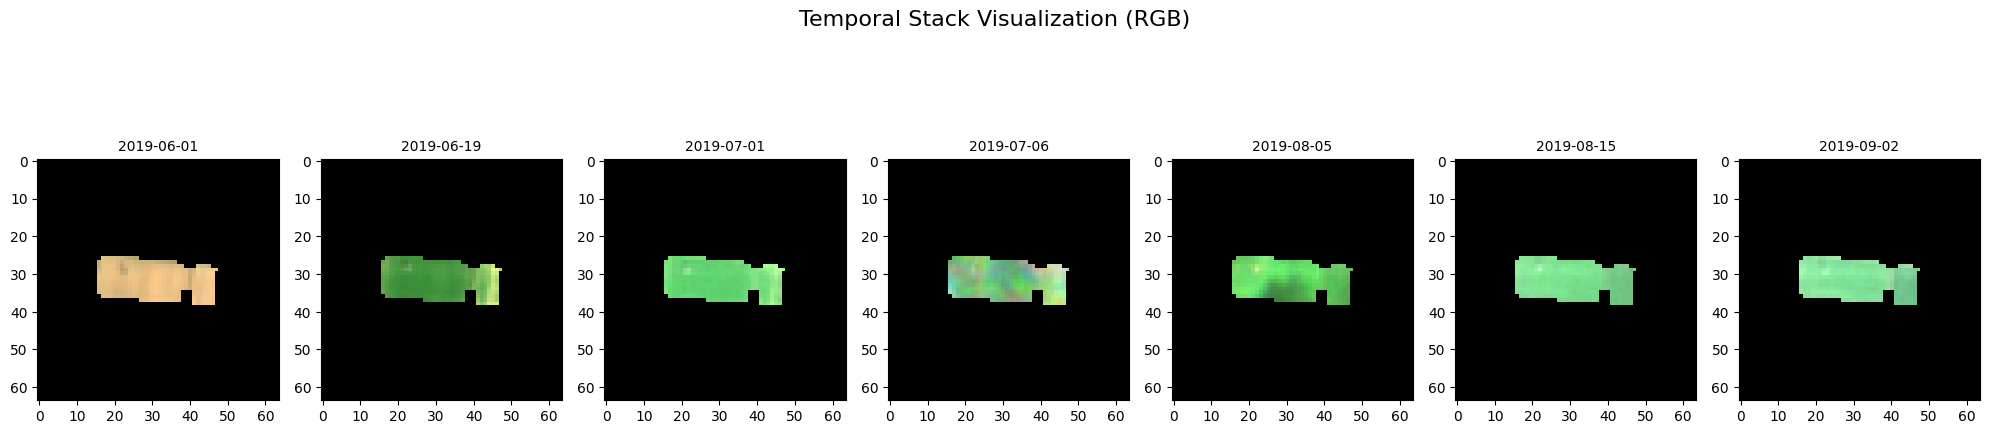

In [ ]:
visualize_temporal_stack_rgb(eval_images_box[-26])

In [ ]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([      0., 1196489., 1196747.])

Saved: /home/k64835/SITS-images/output/img_1168039.png
Saved: /home/k64835/SITS-images/output/img_1228889.png
Saved: /home/k64835/SITS-images/output/img_1168663.png
Saved: /home/k64835/SITS-images/output/img_1168692.png
Saved: /home/k64835/SITS-images/output/img_1171179.png


/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/superpixel.py:337: RuntimeWarning: invalid value encountered in divide


Saved: /home/k64835/SITS-images/output/img_1172001.png
Saved: /home/k64835/SITS-images/output/img_1174805.png
Saved: /home/k64835/SITS-images/output/img_1176318.png
Saved: /home/k64835/SITS-images/output/img_1176365.png
Saved: /home/k64835/SITS-images/output/img_1177274.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1178038.png
Saved: /home/k64835/SITS-images/output/img_1178198.png
Saved: /home/k64835/SITS-images/output/img_1179855.png
Saved: /home/k64835/SITS-images/output/img_1182776.png
Saved: /home/k64835/SITS-images/output/img_1182822.png
Saved: /home/k64835/SITS-images/output/img_1183171.png
Saved: /home/k64835/SITS-images/output/img_1194806.png
Saved: /home/k64835/SITS-images/output/img_1196327.png
Saved: /home/k64835/SITS-images/output/img_1196347.png
Saved: /home/k64835/SITS-images/output/img_1196489.png
Saved: /home/k64835/SITS-images/output/img_1216230.png
Saved: /ho

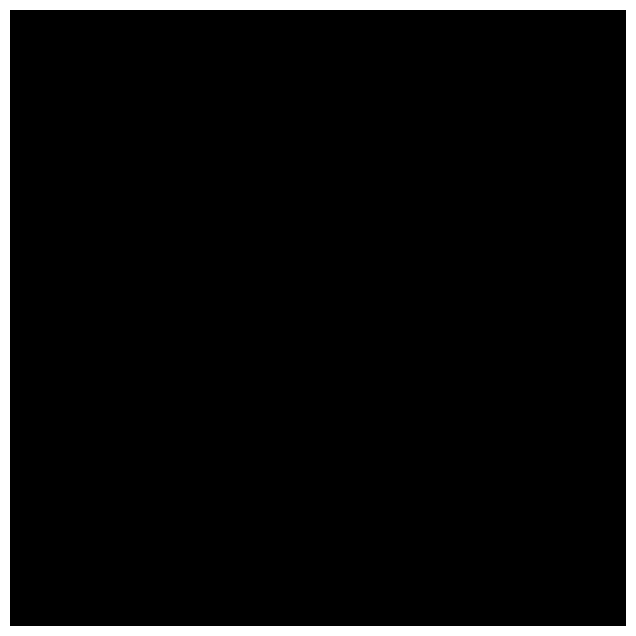

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.save_path)

## Temp Cells 

### Modeling - kmeans

In [ ]:
image_tensor_train.shape

In [ ]:
data_flattened_train = image_tensor_train.reshape(image_tensor_train.size(0), -1).numpy()
data_flattened_train.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=46)
kmeans.fit(data_flattened_train)

In [ ]:
flattened_data_test = image_tensor_eval.reshape(image_tensor_eval.size(0), -1).numpy()

In [ ]:
test_cluster_labels = kmeans.predict(flattened_data_test)

In [ ]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_eval, test_cluster_labels, config.labels_path)
accuracy

In [ ]:
pred_aligned[0], gt_aligned[0]

### Feature Extraction